# Disaster Tweet Classification - RidgeClassifierCV
## NLP with Disaster Tweets
------------------
### GOAL
- Predicting whether a given tweet is about a real disaster or not
- if so, predict a `1`. if not, predict a `0`


### Reference
- [competition main page](https://www.kaggle.com/c/nlp-getting-started)
- [example code](https://www.kaggle.com/datarohitingole/disaster-tweet-classification-ridgeclassifiercv)
- [comparing the performance of different Machine Learning Algorithm](https://dibyendudeb.com/comparing-machine-learning-algorithms/)

# 0. Importing Libraries

In [1]:
# for loading and preprocessing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

# for training the model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree, linear_model, neighbors, naive_bayes, ensemble
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# for evaluating classification model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Comparing all machine learning algorithms
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve

# 2. Data Preprocessing
## Contents
1. Dealing with Missing Values
2. Convert Text to Vectors using Count Vectorizer

## Data Description
--------------
### Files
- `train.csv` : the training set
- `test.csv` : the test set
- `sample_submission.csv` : a sample submission file in the correct format

### Columns
- `id` : a unique identifier for each tweet
- `text` : the text of the tweet
- `keyword` : a particular keyword from th tweet
- `target` : in train.csv only, this denotes whether a tweet is about a real disaster(1) or not(0)

In [30]:
# loading the .csv form data
TRAIN_PATH = './data/origin_train.csv'
TEST_PATH = './data/origin_test.csv'
LABELED_DISAST_PATH = './data/labeled_disaster_data.csv'
LABELED_NONDISAST_PATH = './data/labeled_nondisaster_data.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

labeld_disast = pd.read_csv(LABELED_DISAST_PATH)
labeld_nondisast = pd.read_csv(LABELED_NONDISAST_PATH)

In [10]:
print('train_shape: ', train.shape)
print('test_shape: ', test.shape)
print('label_disast: ', labeld_disast.shape)
print('label_nondisast: ', labeld_nondisast.shape)

train_shape:  (7613, 4)
test_shape:  (3263, 3)
label_disast:  (400, 4)
label_nondisast:  (400, 4)


In [31]:
train = pd.concat([train, labeld_disast, labeld_nondisast])
all_data = [train, test]

print(train.shape)
print(test.shape)

(8413, 4)
(3263, 3)


In [12]:
for data in all_data:
    data.drop(["Unnamed: 0"], axis = 1, inplace = True)
    data.dropna(axis=0, how='any')

In [13]:
train.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
test.head()

,keyword,text
0,NaN,Just happened a terrible car crash
1,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 2-1. Dealing with Missing Values

In [15]:
# data prepocessing with regrex

def remove_URL(text): # remove url pattern in text
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text): # remove html pattern in text
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html.sub(r'', text)
    #return re.sub(html, '', text)

def remove_punct(text): # remove punctuation in text: (;, ', ", :, ., , etc..)
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [17]:
for data in all_data:
  data['text'] = data['text'].apply(lambda x: remove_URL(x))
  data['text'] = data['text'].apply(lambda x: remove_html(x))
  data['text'] = data['text'].apply(lambda x: remove_punct(x))

## 2-1. Convert Text to Vectors using Count Vectorizer

### What is the Count Vectorizer?
- convert a collection of text documents to a matrix of token counts

### How to Use
```python
# python example code
corpus = ["This is the first document", "This document is the second document", "And this is the thrid one"]
vectorize = CounterVectorize()
X = vectorize.fit_transform(corpus)
```
- vectorizer.get_feature_names_out()
> array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this'], ...)
- X.toarray()
> [[0 1 1 1 0 0 1 0 1]  
 [0 2 0 1 0 1 1 0 1]  
 [1 0 0 1 1 0 1 1 1]]


In [18]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=2000)

X = count_vectorizer.fit_transform(train["text"]).toarray()
test = count_vectorizer.transform(test["text"]).toarray()
y = train['target']

In [19]:
# split the data <train : test = 8 : 2>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [20]:
y_test

7427    1
3542    1
1467    0
124     0
3873    0
       ..
7149    0
3518    0
7415    0
5731    1
5782    0
Name: target, Length: 1683, dtype: int64

# 3. Model
## Contents
1. Dealing with Missing Values
2. RidgeClassifierCV

## Model Description
--------------
### Ensemble
- Combine the predictions of several base estimators built with a given learning algorithm 
    - in order to improve generalizability / robustness over a single estimator.
- Boosting of Ensemble types

### Performance - f1-score


In [21]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    XGBClassifier(),
    CatBoostClassifier()  
    ]

In [22]:
row_index = 0
MLA_compare = pd.DataFrame()

for classifier in MLA:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    classifier_accuracy_score = accuracy_score(y_test, y_pred)


    MLA_name = classifier.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score*100

    print(MLA_name, "Done")
    row_index+=1

AdaBoostClassifier Done
BaggingClassifier Done
ExtraTreesClassifier Done
GradientBoostingClassifier Done
RandomForestClassifier Done
PassiveAggressiveClassifier Done
RidgeClassifierCV Done
SGDClassifier Done
Perceptron Done
BernoulliNB Done
GaussianNB Done
KNeighborsClassifier Done
DecisionTreeClassifier Done
ExtraTreeClassifier Done


/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Done
Learning rate set to 0.087207
0:	learn: 1.0505079	total: 70.6ms	remaining: 1m 10s
1:	learn: 1.0088634	total: 79.4ms	remaining: 39.6s
2:	learn: 0.9725010	total: 88.2ms	remaining: 29.3s
3:	learn: 0.9402774	total: 96.9ms	remaining: 24.1s
4:	learn: 0.9125754	total: 105ms	remaining: 21s
5:	learn: 0.8845243	total: 114ms	remaining: 19s
6:	learn: 0.8593988	total: 123ms	remaining: 17.5s
7:	learn: 0.8373221	total: 132ms	remaining: 16.3s
8:	learn: 0.8176205	total: 140ms	remaining: 15.4s
9:	learn: 0.7984852	total: 149ms	remaining: 14.8s
10:	learn: 0.7819874	total: 158ms	remaining: 14.2s
11:	learn: 0.7661319	total: 167ms	rem

170:	learn: 0.4884241	total: 1.61s	remaining: 7.82s
171:	learn: 0.4879286	total: 1.62s	remaining: 7.81s
172:	learn: 0.4874848	total: 1.63s	remaining: 7.79s
173:	learn: 0.4871435	total: 1.64s	remaining: 7.78s
174:	learn: 0.4866211	total: 1.65s	remaining: 7.77s
175:	learn: 0.4861739	total: 1.66s	remaining: 7.75s
176:	learn: 0.4858454	total: 1.67s	remaining: 7.74s
177:	learn: 0.4853844	total: 1.67s	remaining: 7.73s
178:	learn: 0.4850007	total: 1.68s	remaining: 7.72s
179:	learn: 0.4845220	total: 1.69s	remaining: 7.71s
180:	learn: 0.4840981	total: 1.7s	remaining: 7.7s
181:	learn: 0.4835497	total: 1.71s	remaining: 7.69s
182:	learn: 0.4833329	total: 1.72s	remaining: 7.67s
183:	learn: 0.4830534	total: 1.73s	remaining: 7.67s
184:	learn: 0.4826896	total: 1.74s	remaining: 7.65s
185:	learn: 0.4821333	total: 1.75s	remaining: 7.64s
186:	learn: 0.4816473	total: 1.75s	remaining: 7.63s
187:	learn: 0.4811396	total: 1.76s	remaining: 7.62s
188:	learn: 0.4807459	total: 1.77s	remaining: 7.6s
189:	learn: 0.4

330:	learn: 0.4418772	total: 3.04s	remaining: 6.15s
331:	learn: 0.4416078	total: 3.05s	remaining: 6.14s
332:	learn: 0.4412777	total: 3.06s	remaining: 6.13s
333:	learn: 0.4409456	total: 3.07s	remaining: 6.12s
334:	learn: 0.4407973	total: 3.08s	remaining: 6.11s
335:	learn: 0.4405138	total: 3.09s	remaining: 6.11s
336:	learn: 0.4401447	total: 3.1s	remaining: 6.1s
337:	learn: 0.4399791	total: 3.11s	remaining: 6.09s
338:	learn: 0.4398113	total: 3.12s	remaining: 6.08s
339:	learn: 0.4397228	total: 3.13s	remaining: 6.07s
340:	learn: 0.4395383	total: 3.13s	remaining: 6.06s
341:	learn: 0.4393085	total: 3.14s	remaining: 6.05s
342:	learn: 0.4390824	total: 3.15s	remaining: 6.04s
343:	learn: 0.4389627	total: 3.16s	remaining: 6.03s
344:	learn: 0.4387691	total: 3.17s	remaining: 6.02s
345:	learn: 0.4385878	total: 3.18s	remaining: 6.02s
346:	learn: 0.4384301	total: 3.19s	remaining: 6.01s
347:	learn: 0.4381950	total: 3.2s	remaining: 6s
348:	learn: 0.4380626	total: 3.21s	remaining: 5.99s
349:	learn: 0.4378

490:	learn: 0.4144782	total: 4.46s	remaining: 4.63s
491:	learn: 0.4143730	total: 4.47s	remaining: 4.62s
492:	learn: 0.4142301	total: 4.48s	remaining: 4.61s
493:	learn: 0.4141256	total: 4.49s	remaining: 4.6s
494:	learn: 0.4139739	total: 4.5s	remaining: 4.59s
495:	learn: 0.4138069	total: 4.51s	remaining: 4.58s
496:	learn: 0.4136765	total: 4.51s	remaining: 4.57s
497:	learn: 0.4135613	total: 4.52s	remaining: 4.56s
498:	learn: 0.4134390	total: 4.53s	remaining: 4.55s
499:	learn: 0.4133082	total: 4.54s	remaining: 4.54s
500:	learn: 0.4131010	total: 4.55s	remaining: 4.53s
501:	learn: 0.4130499	total: 4.56s	remaining: 4.52s
502:	learn: 0.4129079	total: 4.57s	remaining: 4.51s
503:	learn: 0.4127111	total: 4.57s	remaining: 4.5s
504:	learn: 0.4125728	total: 4.58s	remaining: 4.49s
505:	learn: 0.4124466	total: 4.59s	remaining: 4.48s
506:	learn: 0.4123156	total: 4.6s	remaining: 4.47s
507:	learn: 0.4121839	total: 4.61s	remaining: 4.46s
508:	learn: 0.4120352	total: 4.62s	remaining: 4.46s
509:	learn: 0.41

668:	learn: 0.3931916	total: 6.08s	remaining: 3.01s
669:	learn: 0.3930277	total: 6.09s	remaining: 3s
670:	learn: 0.3929279	total: 6.1s	remaining: 2.99s
671:	learn: 0.3928565	total: 6.11s	remaining: 2.98s
672:	learn: 0.3927285	total: 6.12s	remaining: 2.97s
673:	learn: 0.3925958	total: 6.13s	remaining: 2.96s
674:	learn: 0.3924381	total: 6.14s	remaining: 2.95s
675:	learn: 0.3923250	total: 6.14s	remaining: 2.94s
676:	learn: 0.3922238	total: 6.15s	remaining: 2.94s
677:	learn: 0.3921333	total: 6.16s	remaining: 2.93s
678:	learn: 0.3920599	total: 6.17s	remaining: 2.92s
679:	learn: 0.3919099	total: 6.18s	remaining: 2.91s
680:	learn: 0.3917922	total: 6.19s	remaining: 2.9s
681:	learn: 0.3916077	total: 6.2s	remaining: 2.89s
682:	learn: 0.3914688	total: 6.21s	remaining: 2.88s
683:	learn: 0.3913838	total: 6.21s	remaining: 2.87s
684:	learn: 0.3913070	total: 6.22s	remaining: 2.86s
685:	learn: 0.3912433	total: 6.23s	remaining: 2.85s
686:	learn: 0.3910753	total: 6.24s	remaining: 2.84s
687:	learn: 0.3909

829:	learn: 0.3781950	total: 7.51s	remaining: 1.54s
830:	learn: 0.3781125	total: 7.52s	remaining: 1.53s
831:	learn: 0.3780421	total: 7.52s	remaining: 1.52s
832:	learn: 0.3779939	total: 7.53s	remaining: 1.51s
833:	learn: 0.3779507	total: 7.54s	remaining: 1.5s
834:	learn: 0.3778885	total: 7.55s	remaining: 1.49s
835:	learn: 0.3777388	total: 7.56s	remaining: 1.48s
836:	learn: 0.3776088	total: 7.57s	remaining: 1.47s
837:	learn: 0.3775521	total: 7.58s	remaining: 1.46s
838:	learn: 0.3774808	total: 7.58s	remaining: 1.46s
839:	learn: 0.3773978	total: 7.59s	remaining: 1.45s
840:	learn: 0.3773309	total: 7.6s	remaining: 1.44s
841:	learn: 0.3771743	total: 7.61s	remaining: 1.43s
842:	learn: 0.3771059	total: 7.62s	remaining: 1.42s
843:	learn: 0.3770472	total: 7.63s	remaining: 1.41s
844:	learn: 0.3769282	total: 7.64s	remaining: 1.4s
845:	learn: 0.3768949	total: 7.64s	remaining: 1.39s
846:	learn: 0.3768345	total: 7.65s	remaining: 1.38s
847:	learn: 0.3767269	total: 7.66s	remaining: 1.37s
848:	learn: 0.3

991:	learn: 0.3649964	total: 8.92s	remaining: 71.9ms
992:	learn: 0.3648836	total: 8.93s	remaining: 63ms
993:	learn: 0.3648322	total: 8.94s	remaining: 54ms
994:	learn: 0.3647905	total: 8.95s	remaining: 45ms
995:	learn: 0.3647511	total: 8.96s	remaining: 36ms
996:	learn: 0.3646454	total: 8.97s	remaining: 27ms
997:	learn: 0.3646186	total: 8.98s	remaining: 18ms
998:	learn: 0.3644950	total: 8.98s	remaining: 8.99ms
999:	learn: 0.3643844	total: 8.99s	remaining: 0us
CatBoostClassifier Done


In [28]:
MLA_compare = MLA_compare.sort_values(by="MLA Name", ascending=False).reset_index(drop=True)
MLA_compare

KeyError: 'MLA Name'

# Comapring all MLA
- precision
- recall
- accuracy
- f1-score

In [16]:
2/3

0.6666666666666666

In [ ]:
# Comparing all machine learning algorithms
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from tqdm import tqdm

row_index = 0
MLA_columns = []
MLA_compare = pd.DataFrame(columns=MLA_columns)

for alg in tqdm(MLA):
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)

    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    
    
    recall = recall_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'Precission'] = precision
    MLA_compare.loc[row_index, 'Recall'] = recall
    MLA_compare.loc[row_index, 'F1-score'] = round((2*precision*recall)/(precision+recall),4)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

    row_index+=1

In [25]:
# f1-score 기준 정렬
MLA_compare.sort_values(by = ['F1-score'], ascending = False, inplace = True)    
MLA_compare

,MLA used,Train Accuracy,Test Accuracy,Precission,Recall,F1-score,AUC
2,ExtraTreesClassifier,0.9837,0.7962,0.790268,0.683599,0.7331,0.778922
1,BaggingClassifier,0.9654,0.7558,0.741319,0.619739,0.6751,0.734920
0,AdaBoostClassifier,0.4508,0.4777,0.431655,0.870827,0.5772,0.538029


Text(0.5, 0, 'Algorithm Name')

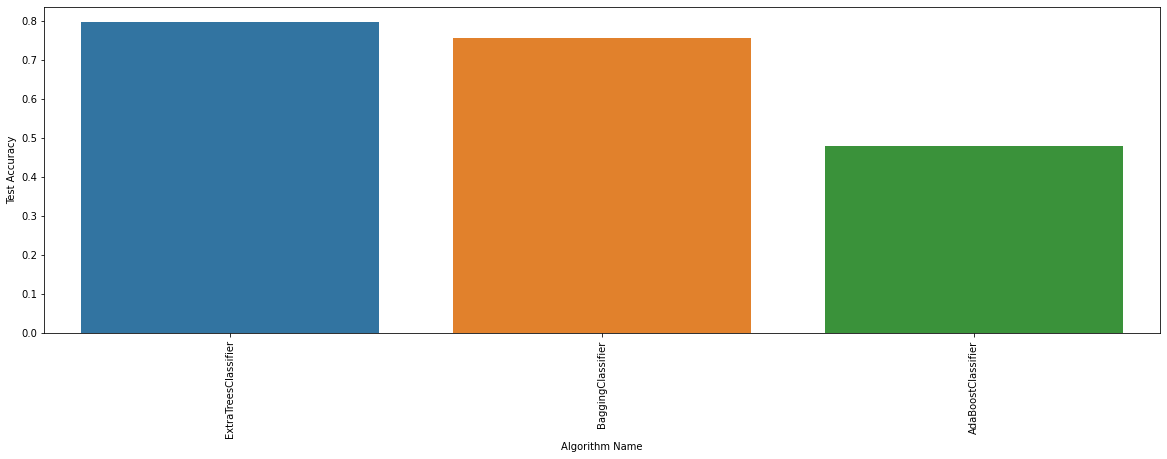

In [26]:
plt.rcParams["figure.figsize"] = (20,6)
sns.barplot(x="MLA used", y="Test Accuracy", data = MLA_compare)
plt.xticks(rotation=90)
plt.xlabel("Algorithm Name")

In [27]:
classifier = linear_model.RidgeClassifierCV(cv=15)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Accuracy Score : ", accuracy_score(y_test, y_pred), "\n\n")
print(confusion_matrix(y_test, y_pred))

/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"


Accuracy Score :  0.8074866310160428 


[[899  95]
 [229 460]]


In [ ]:
sample_submission = pd.read_csv(data_path + "sample_submission.csv")
sample_submission

In [ ]:
test_pred = classifier.predict(test)

In [ ]:
output = pd.DataFrame({'id': sample_submission.id, 'target': test_pred})
output.to_csv(data_path+'submission.csv', index=False)